In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:
import numpy as np
import time
import tensorflow as tf
from mpl_toolkits.mplot3d import Axes3D
from collections import namedtuple
import os

In [3]:
from eventcnn.datasources.davis import DavisDataset
from eventcnn.datasources.eventsource import EventSource, CachedDenseEventSource

In [4]:
source = CachedDenseEventSource("data/dense")

In [5]:
N_EVENT_SLICES = source.event_slices
BATCH_SIZE = 8
N_EVENT_ROWS = source.rows
N_EVENT_COLS = source.cols
LABEL_SCALE_FACTOR = np.float32(1.0 / np.max(np.abs(source.training()["labels"])))  # Rescale the positions to be in the range [-1, 1]

In [6]:
# Copied from the tensorflow tutorial in class
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape, stddev=0.01))

def init_bias(shape):
    return tf.Variable(tf.zeros(shape))

In [7]:
def n_output_channels(layer):
    return layer.get_shape()[-1].value

def n_outputs(layer):
    out = layer.get_shape()[1].value
    for d in layer.get_shape()[2:]:
        out *= d.value
    return out


In [10]:
WeightBias = namedtuple("WeightBias", ["weights", "bias"])

In [11]:
input_tensor = tf.placeholder(tf.float32, [None, 
                                           N_EVENT_COLS, 
                                           N_EVENT_ROWS, 
                                           N_EVENT_SLICES, 
                                           2])
dropout_keep_prob = tf.placeholder(tf.float32)

weight_vars = {"conv1": WeightBias(init_weights([3, 3, 3, 2, 6]),
                        init_bias(6))}
conv1 = tf.nn.conv3d(input_tensor, weight_vars["conv1"].weights, 
                     strides=[1,1,1,1,1], padding='SAME')
conv1 = tf.nn.relu(tf.nn.bias_add(conv1, weight_vars["conv1"].bias))
pool1 = tf.nn.max_pool3d(conv1, ksize=[1, 2, 2, 2, 1], 
                         strides=[1, 2, 2, 2, 1], padding="SAME")

weight_vars["conv2"] = WeightBias(init_weights([3,3,2, n_output_channels(pool1),6]),
                                  init_bias(6))
conv2 = tf.nn.conv3d(pool1, 
                     weight_vars["conv2"].weights, 
                     strides=[1, 1, 1, 1, 1], padding="SAME")
conv2 = tf.nn.relu(tf.nn.bias_add(conv2, weight_vars["conv2"].bias))
pool2 = tf.nn.max_pool3d(conv1, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding="SAME")

weight_vars["fc3"] = WeightBias(init_weights([n_outputs(pool2), 32]),
                                init_bias(32))
fc3 = tf.reshape(pool2, [-1, n_outputs(pool2)])
fc3 = tf.add(tf.matmul(fc3, weight_vars["fc3"].weights), weight_vars["fc3"].bias)
fc3 = tf.nn.relu(fc3)
fc3 = tf.nn.dropout(fc3, dropout_keep_prob)

weight_vars["out"] = WeightBias(init_weights([n_outputs(fc3), 3]),
                                init_bias(3))
out = tf.add(tf.matmul(fc3, weight_vars["out"].weights), weight_vars["out"].bias)

y = tf.placeholder(tf.float32, [None, 3])

loss = tf.nn.l2_loss(tf.sub(out, tf.mul(LABEL_SCALE_FACTOR, y)))
avg_loss = tf.reduce_mean(loss)
train_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

init = tf.initialize_all_variables()

saver = tf.train.Saver()

In [ ]:
TRAINING_STEPS = 10

sess = tf.Session()
sess.run(init)

os.makedirs("models", exist_ok=True)

for step in range(TRAINING_STEPS):
    for i in range(0, source.num_training - BATCH_SIZE, BATCH_SIZE):
        print("training step: {:d}, batch starting index: {:d}".format(step, i))
        events = source.training()["events"][i:(i+BATCH_SIZE),:,...,:]
        labels = source.training()["labels"][i:(i+BATCH_SIZE),:]
        sess.run(train_optimizer, feed_dict={input_tensor: events,
                                             y: labels,
                                             dropout_keep_prob: 0.5})

    events_test = source.testing()["events"]
    labels_test = source.testing()["labels"]
    avg = sess.run(avg_loss, feed_dict={input_tensor: events_test,
                                        y: labels_test,
                                        dropout_keep_prob: 1.0})
    print("average loss on test set:", avg)
    saver.save(sess, "models/model.ckpt")
    print("model saved")
avg

training step: 0, batch starting index: 0
training step: 0, batch starting index: 8
training step: 0, batch starting index: 16
training step: 0, batch starting index: 24
training step: 0, batch starting index: 32
training step: 0, batch starting index: 40


In [15]:
w = sess.run(weight_vars["conv1"].weights)

In [16]:
w.shape

(3, 3, 3, 2, 6)

/usr/local/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


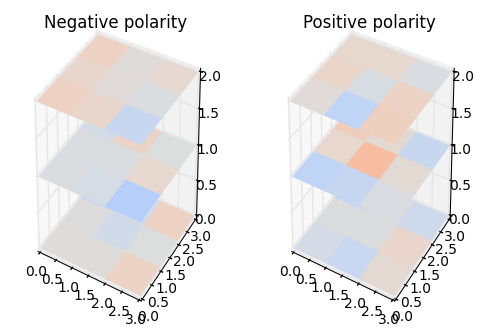

In [17]:
def get_color(data):
    return cm.coolwarm((data + 0.1) / 0.2)


def plot_weights_3d(ax, data):
    for z in range(3):
        X, Y = np.meshgrid(np.arange(0, 4), np.arange(0, 4))
        Z = z * np.ones_like(X)
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, facecolors=get_color(data[:,:,z]), shade=False)

fig = figure()
ax = fig.add_subplot(121, projection='3d')
plot_weights_3d(ax, w[:,:,:,0,2])
title("Negative polarity")
ax = fig.add_subplot(122, projection='3d')
plot_weights_3d(ax, w[:,:,:,1,2])
title("Positive polarity")

In [35]:
for i in range(300, 310):
    predicted = sess.run(out, feed_dict={input_tensor: events_test[i:i+1,:,...,:],
                              dropout_keep_prob: 1.0})
    expected = labels_test[i,:] * LABEL_SCALE_FACTOR
    print(predicted, expected)
    
    

[[ 0.04858004 -0.01885871  0.22752345]] [ 0.17983006  0.00991803  0.31131885]
[[ 0.04541124 -0.08600274  0.22425401]] [ 0.1455377  -0.09076043  0.32053913]
[[ 0.06757558 -0.17789648  0.21323046]] [ 0.11902007 -0.21586782  0.26943445]
[[ 0.04442695 -0.24243475  0.11785519]] [ 0.08826034 -0.30073109  0.12922202]
[[-0.65225393 -0.06572773  0.0506635 ]] [-0.99999996  0.02273928 -0.02912681]
[[-0.61473304 -0.18607198 -0.03558802]] [-0.85993918 -0.01095871 -0.08534932]
[[-0.34829828 -0.12457481 -0.03907385]] [-0.41210448 -0.03320092 -0.07030027]
[[-0.13196468 -0.06600909 -0.00906137]] [-0.24304062 -0.06833804 -0.04083941]
[[ 0.19517994 -0.09093244 -0.01894782]] [ 0.27753652 -0.10069298  0.03405901]
[[ 0.26592803 -0.08430974  0.06055763]] [ 0.54589589 -0.06677153  0.07638897]
